In [3]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import os
os.chdir(caffe_root)
import sys
sys.path.insert(0, 'python')
#sys.path.append("/Users/marissac/Documents/COCOText/coco-text-master")
sys.path.append("/Users/marissac/Documents/COCOText/github/coco-text")
import caffe
import coco_text
import coco_evaluation
import skimage.io as io
import cv2
import math
import sys
from google.protobuf import text_format
from caffe.proto import caffe_pb2
import pickle
import glob
import json

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

CAFFE_LABEL_TO_CHAR_MAP = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
    10: 'a',
    11: 'b',
    12: 'c',
    13: 'd',
    14: 'e',
    15: 'f',
    16: 'g',
    17: 'h',
    18: 'i',
    19: 'j',
    20: 'k',
    21: 'l',
    22: 'm',
    23: 'n',
    24: 'o',
    25: 'p',
    26: 'q',
    27: 'r',
    28: 's',
    29: 't',
    30: 'u',
    31: 'v',
    32: 'w',
    33: 'x',
    34: 'y',
    35: 'z',
    36: ' ',
    37: '\0',
    38: '\0'
}

def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    #print num_labels
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames
    
def ssd_detect_box(image,caffe_net=None, caffe_transformer=None,confidence_threshold = 0.22,image_resize = 300,multiclass_flag = 1,text_class = 81):
    # Set up network and transform image
    caffe_net.blobs['data'].reshape(1,3,image_resize,image_resize)
    transformed_image = caffe_transformer.preprocess('data',image)
    caffe_net.blobs['data'].data[...] = transformed_image
    
    # Get detection results for image
    caffe_net.forward()
    detections_out = caffe_net.blobs['detection_out'].data
    
    det_label = detections_out[0,0,:,1]
    det_conf = detections_out[0,0,:,2]
    det_xmin = detections_out[0,0,:,3]
    det_ymin = detections_out[0,0,:,4]
    det_xmax = detections_out[0,0,:,5]
    det_ymax = detections_out[0,0,:,6]
    
    if multiclass_flag == 1:
        class_indices = [i for i, label in enumerate(det_label) if label == text_class]
        det_conf = det_conf[class_indices]
        det_label = det_label[class_indices]
        det_xmin = det_xmin[class_indices]
        det_ymin = det_ymin[class_indices]
        det_xmax = det_xmax[class_indices]
        det_ymax = det_ymax[class_indices]


    top_indices = [i for i, conf in enumerate(det_conf) if conf > confidence_threshold]
    top_conf = det_conf[top_indices]
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    num_detect = top_conf.shape[0]
    
    # Get the detections in the format needed for COCOText detection evaliations
    detection_results = []
    for i in range(0,num_detect):
        xmin_pix = top_xmin[i] * image.shape[1]
        ymin_pix = top_ymin[i] * image.shape[0]
        width_pix = top_xmax[i] * image.shape[1] - xmin_pix
        height_pix = top_ymax[i] * image.shape[0] - ymin_pix
        top_width = top_xmax[i] - top_xmin[i]
        top_height = top_ymax[i] - top_ymin[i]
        bboxTemp = [top_xmin[i], top_ymin[i],top_width,top_height]
        area = width_pix*height_pix
        detection_results.append({'bounding_box':bboxTemp,'label':i,'score':top_conf[i],'area':area})
        
    return detection_results
    
def synth_read_words(image,detection_boxes,CAFFE_LABEL_TO_CHAR_MAP,net_synth=None, synth_transformer=None):
    img_shape = image.shape
    gray_img = np.empty((image.shape[0],image.shape[1],1))
    gray_img_temp = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_img[:,:,0] = gray_img_temp
    
    
    num_detections = len(detection_boxes)
    for i in range(0,num_detections):
        bboxTemp = detection_boxes[i]['bounding_box']
        x_min_pix = int(math.floor(bboxTemp[0]*image.shape[1]))
        y_min_pix = int(math.floor(bboxTemp[1]*image.shape[0]))
        x_max_pix = int(math.ceil(bboxTemp[0]*image.shape[1] + bboxTemp[2]*image.shape[1])) 
        y_max_pix = int(math.ceil(bboxTemp[1]*image.shape[0] + bboxTemp[3]*image.shape[0]))
        text_img = gray_img[y_min_pix:y_max_pix,x_min_pix:x_max_pix]
        synth_transform_image = synth_transformer.preprocess('data',text_img)
        plt.figure(i+1)
        plt.imshow(synth_transform_image[0,:,:])
        net_synth.blobs['data'].data[0,0,:,:] = synth_transform_image[0,:,:]
        net_synth.forward()
        output = net_synth.blobs['reshape'].data
        text_out = np.reshape(output,(39,23))
        text_max = np.argmax(text_out, axis=0) 
        output_word = ''
        for j in range(0,23):
            output_word = output_word + CAFFE_LABEL_TO_CHAR_MAP[text_max[j]-1]
            
        detection_boxes[i]['text'] = output_word.strip()
    return detection_boxes

# Define the network to use for text detection
model_def = '/Users/marissac/caffe/models/VGGNet/cocoText/SSD_300x300/deploy_digitIn_multiclass.prototxt'
model_weights = '/Users/marissac/caffe/examples/ssd/models/VGGNet/cocoText/SSD_300x300/VGG_cocoText_SSD_300x300_multiclass_corr_iter_204000.caffemodel'
net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)
                
# Define the word reader network
synth_model = '/Users/marissac/caffe/examples/ocr/90ksynth/deploy_2.prototxt'
synth_model_weights = '/Users/marissac/caffe/examples/ocr/90ksynth/90ksynth_v2_v00_iter_140000.caffemodel'

net_synth = caffe.Net(synth_model,
                     synth_model_weights,
                     caffe.TEST)
                
# Define the image data transformer
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

# Define the data tranformer for the word reader
mean_blob = caffe.proto.caffe_pb2.BlobProto()
data_use = open('/Users/marissac/caffe/examples/ocr/90ksynth/90ksynth_leveldb_mean.binaryproto','rb').read()
mean_blob.ParseFromString(data_use)
mean_arr = np.array( caffe.io.blobproto_to_array(mean_blob) )
mean_val = np.mean(mean_arr)
print mean_val
synth_transformer = caffe.io.Transformer({'data': net_synth.blobs['data'].data.shape})
synth_transformer.set_transpose('data', (2, 0, 1))
synth_transformer.set_mean('data', np.array([mean_val])/256.0)



118.088144832


show
ana
update
new
other
every
on
uesday
available
backyard
episodes
doni
whoonews
vertu
criseii
newepisodese
ignore
sthar
yo
availables
eloorytereeliy
tues


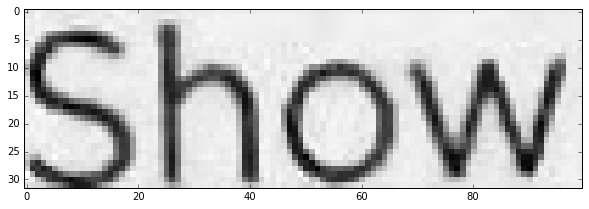

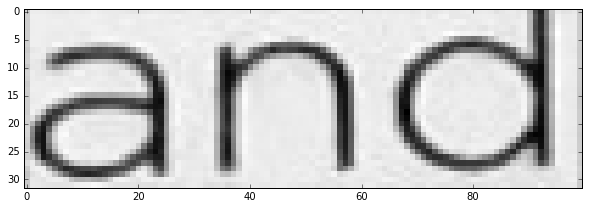

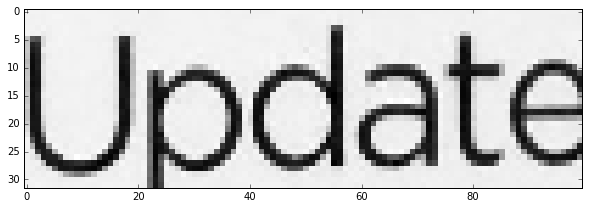

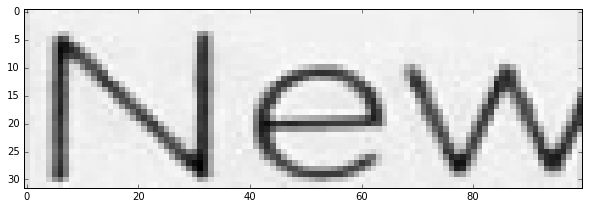

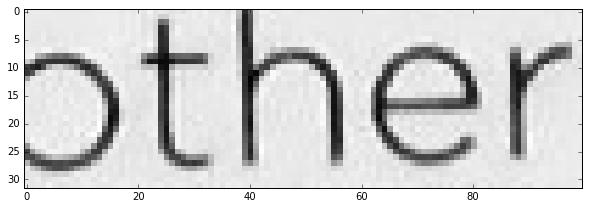

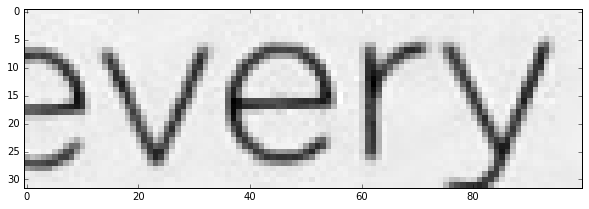

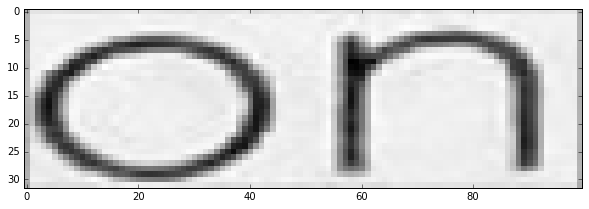

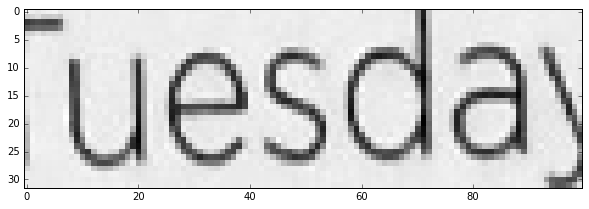

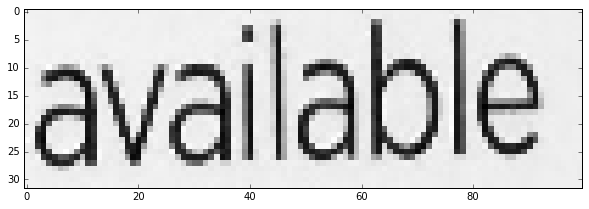

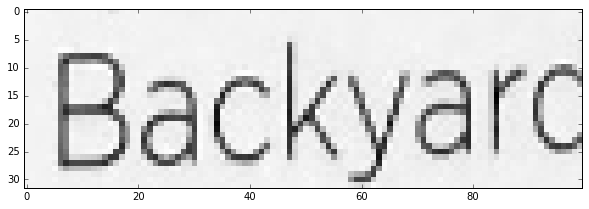

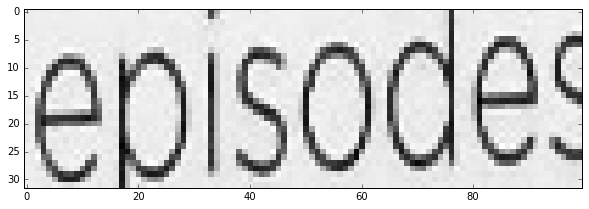

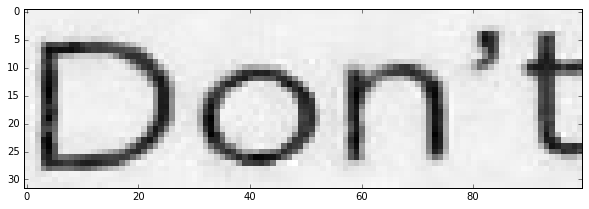

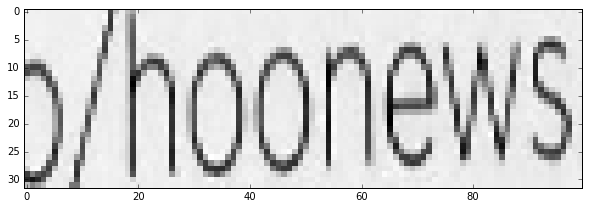

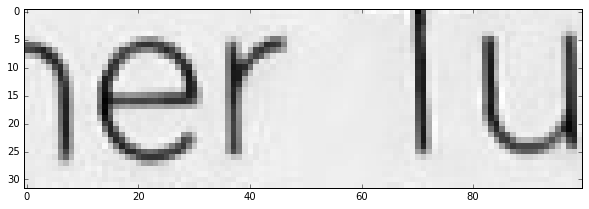

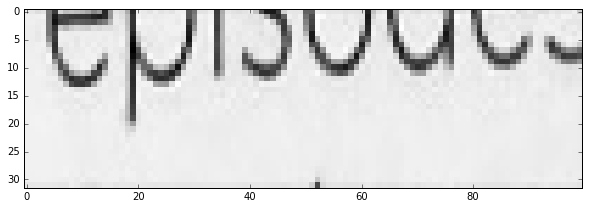

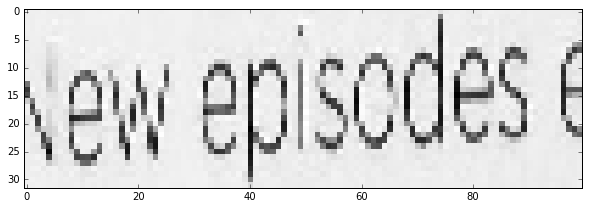

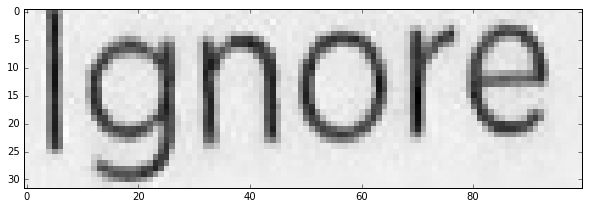

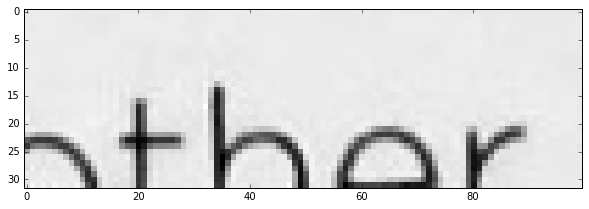

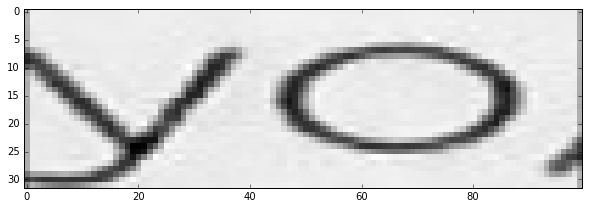

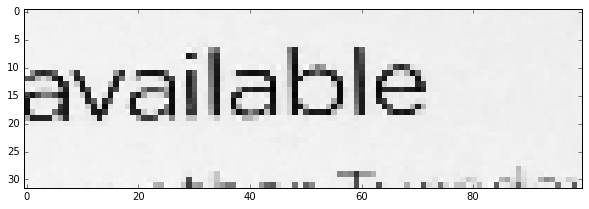

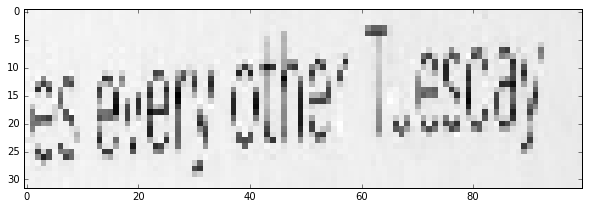

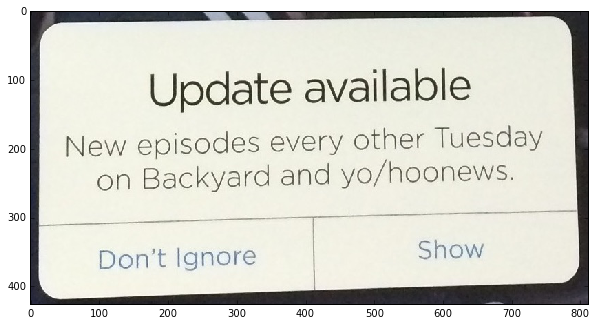

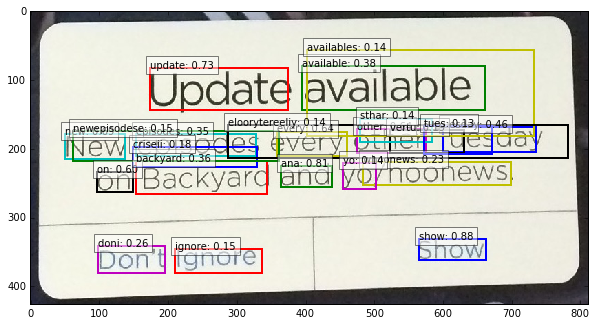

In [4]:
fileName = '/Users/marissac/data/Test_images/yahooNews.jpg'
image = caffe.io.load_image(fileName)
detection_read = []
thresh_use = 0.13
    
detection_read= ssd_detect_box(image,net, transformer,confidence_threshold = thresh_use,image_resize = 300)

detection_read = synth_read_words(image,detection_read,CAFFE_LABEL_TO_CHAR_MAP,net_synth, synth_transformer)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
num_detect = len(detection_read)

plt.figure;
plt.imshow(image)

plt.figure()
plt.imshow(image)
currentAxis = plt.gca()
for i in range(0,num_detect):
    
    xmin = int(round(detection_read[i]['bounding_box'][0] * image.shape[1]))
    ymin = int(round(detection_read[i]['bounding_box'][1] * image.shape[0]))
    xmax = int(round(xmin + detection_read[i]['bounding_box'][2] * image.shape[1] ))
    ymax = int(round(ymin + detection_read[i]['bounding_box'][3] * image.shape[0] ))
    
      
    score = detection_read[i]['score']
    label = detection_read[i]['text']
    name = '%s: %.2f'%(label, score)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[i % len(colors)]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, name, bbox={'facecolor':'white', 'alpha':0.5})
    print label